<a href="https://colab.research.google.com/github/Matheusmatos2916/GANs/blob/main/Livro_Sistem%C3%A1tico_3_Desenvolvimento_de_uma_Rede_Generativa_Adversarial_(GAN)_para_Gera%C3%A7%C3%A3o_de_D%C3%ADgitos_Manuscritos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalar pacotes

In [1]:
!pip install tensorflow keras

### Importar Bibliotecas

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt

### Carregador Dataset

In [3]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normaliza os valores para o intervalo [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)


### Criando o Gerador


In [4]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


### Gerador Discriminador

In [5]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model


### Compilação do Modelo

In [6]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
z = tf.keras.Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

validity = discriminator(img)
combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


### Treinamento

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 32ms/step
7500 [D loss: 0.6652438938617706 | D accuracy: 59.375] [G loss: 0.849608302116394]
1/1 [==============================] - 0s 31ms/step
10000 [D loss: 0.6781122982501984 | D accuracy: 60.9375] [G loss: 0.8412277698516846]
1/1 [==============================] - 0s 47ms/step


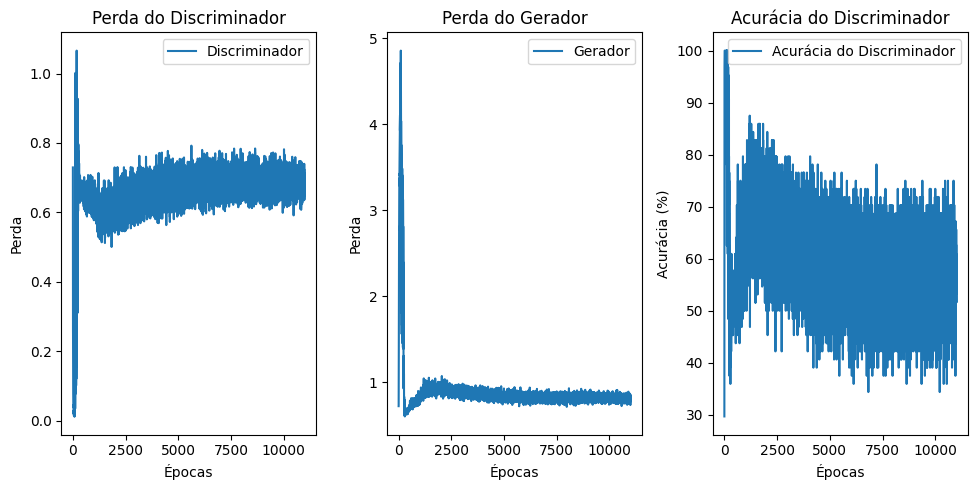

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt

# Carregamento e pré-processamento do dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normaliza os valores para o intervalo [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

# Função para construir o gerador
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Função para construir o discriminador
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compilação dos modelos
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
z = tf.keras.Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

validity = discriminator(img)
combined = tf.keras.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Função para treinar a GAN
def train(epochs, batch_size=128, save_interval=50):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = (X_train - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    # Listas para armazenar as perdas e acurácias
    d_losses = []
    g_losses = []
    d_accuracies = []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        # Armazenar as métricas
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_accuracies.append(100 * d_loss[1])

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_imgs(epoch)

    # Plotar as métricas
    plot_metrics(d_losses, g_losses, d_accuracies)

# Função para salvar as imagens geradas
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"./imagens/mnist_{epoch}.png") # Alterar - diretório desejado
    plt.close()

# Função para plotar as métricas de perda e acurácia
def plot_metrics(d_losses, g_losses, d_accuracies):
    plt.figure(figsize=(10, 5))

    # Plotar a perda do discriminador
    plt.subplot(1, 3, 1)
    plt.plot(d_losses, label="Discriminador")
    plt.xlabel("Épocas")
    plt.ylabel("Perda")
    plt.title("Perda do Discriminador")
    plt.legend()

    # Plotar a perda do gerador
    plt.subplot(1, 3, 2)
    plt.plot(g_losses, label="Gerador")
    plt.xlabel("Épocas")
    plt.ylabel("Perda")
    plt.title("Perda do Gerador")
    plt.legend()

    # Plotar a acurácia do discriminador
    plt.subplot(1, 3, 3)
    plt.plot(d_accuracies, label="Acurácia do Discriminador")
    plt.xlabel("Épocas")
    plt.ylabel("Acurácia (%)")
    plt.title("Acurácia do Discriminador")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Início do treinamento
train(epochs=11000, batch_size=64, save_interval=2500)
